In [128]:
import re
from itertools import product

import joblib
import matplotlib.pyplot as plt
import mplcyberpunk
import numpy as np
import pandas as pd
import shap
import yaml
from IPython.display import HTML
from matplotlib import figure

shap.initjs()

In [129]:
config_path = "../config/params.yml"
config = yaml.load(open(config_path), Loader=yaml.FullLoader)
preproc = config["preprocessing"]

In [130]:
X_test = pd.read_parquet(preproc["test_data_path"])
weeks_test = X_test.pop("WEEK_NUM")
y_test = X_test.pop("target")
X_test

,days30_165L,maritalst_385M,pmtscount_423L,requesttype_4525192L,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avgoutstandbalancel6m_4187114A,cntincpaycont9m_3716944L,cntpmts24_3658933L,...,purposeofcred_active,residualamount_closed,subjectrole_active,subjectrole_closed,empladdr,num_total_inst,num_total_paid_inst,cred_closure_date_days_ago,actualdpd,sellerplace_cnt
case_id,,,,,,,,,,,,,,,,,,,,,
1363221.0,0.0,2.0,NaN,None,2905.0000,7087.0,5636.4000,146023.800,5.0,20.0,...,a55475b1,NaN,a55475b1,a55475b1,a55475b1,50.0,52.0,NaN,0.0,0
1670326.0,2.0,3.0,NaN,DEDUCTION_6,9231.8000,6243.0,5222.4000,116782.664,16.0,20.0,...,a55475b1,0.0,a55475b1,a55475b1,a55475b1,39.0,41.0,-42.0,0.0,3
253536.0,1.0,0.0,NaN,None,2485.2000,0.0,3293.4001,NaN,0.0,12.0,...,a55475b1,NaN,a55475b1,a55475b1,a55475b1,32.0,33.0,-88.0,0.0,6
615071.0,NaN,2.0,NaN,None,5816.8003,0.0,NaN,NaN,NaN,NaN,...,None,NaN,None,None,a55475b1,0.0,NaN,NaN,0.0,1
1894843.0,0.0,0.0,NaN,None,2585.2000,5428.2,6443.2000,153940.050,14.0,23.0,...,a55475b1,NaN,a55475b1,a55475b1,a55475b1,140.0,97.0,-437.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751416.0,2.0,3.0,7.0,None,1800.0000,0.0,NaN,NaN,NaN,NaN,...,60c73645,0.0,a55475b1,a55475b1,P46_103_143,0.0,NaN,-1533.0,0.0,1
622194.0,0.0,2.0,0.0,None,2545.4001,0.0,NaN,NaN,NaN,NaN,...,a55475b1,NaN,a55475b1,a55475b1,P62_116_179,0.0,NaN,NaN,0.0,1
11340.0,0.0,0.0,7.0,None,3175.8000,0.0,NaN,NaN,NaN,NaN,...,a55475b1,NaN,a55475b1,a55475b1,P6_35_77,0.0,NaN,NaN,0.0,0


# Feature importance

Найдем наиболее важные признаки для CatBoost модели.

In [131]:
model = joblib.load(config["train"]["tuned_model_path"])

In [132]:
explainer = shap.TreeExplainer(model, feature_names=X_test.columns)

In [133]:
shap_values_legacy = explainer.shap_values(X_test)

In [134]:
shap_values = explainer(X_test)

In [14]:
def show_beeswarm_plot(shap_values: np.ndarray, dark_mode: bool = True) -> figure:
    """Beeswarm plot

    Parameters
    ----------
    shap_values: np.ndarray
         matrix of SHAP values (# samples x # features).
         Each row sums to the difference between the model output

    dark_mode: bool, default = True
        Use dark theme
    """
    plt.clf()
    if dark_mode:
        plt.style.use("cyberpunk")
    else:
        plt.rcdefaults()
    axis_color = "w" if dark_mode else "black"
    shap.plots.beeswarm(
        shap_values,
        axis_color=axis_color,
        color=plt.get_cmap("cool"),
        show=False,
        max_display=21,
        plot_size=(20, 9),
    )
    plt.tight_layout()
    fig = plt.figure(dpi=600, figsize=(20, 9))
    plt.close()
    return fig

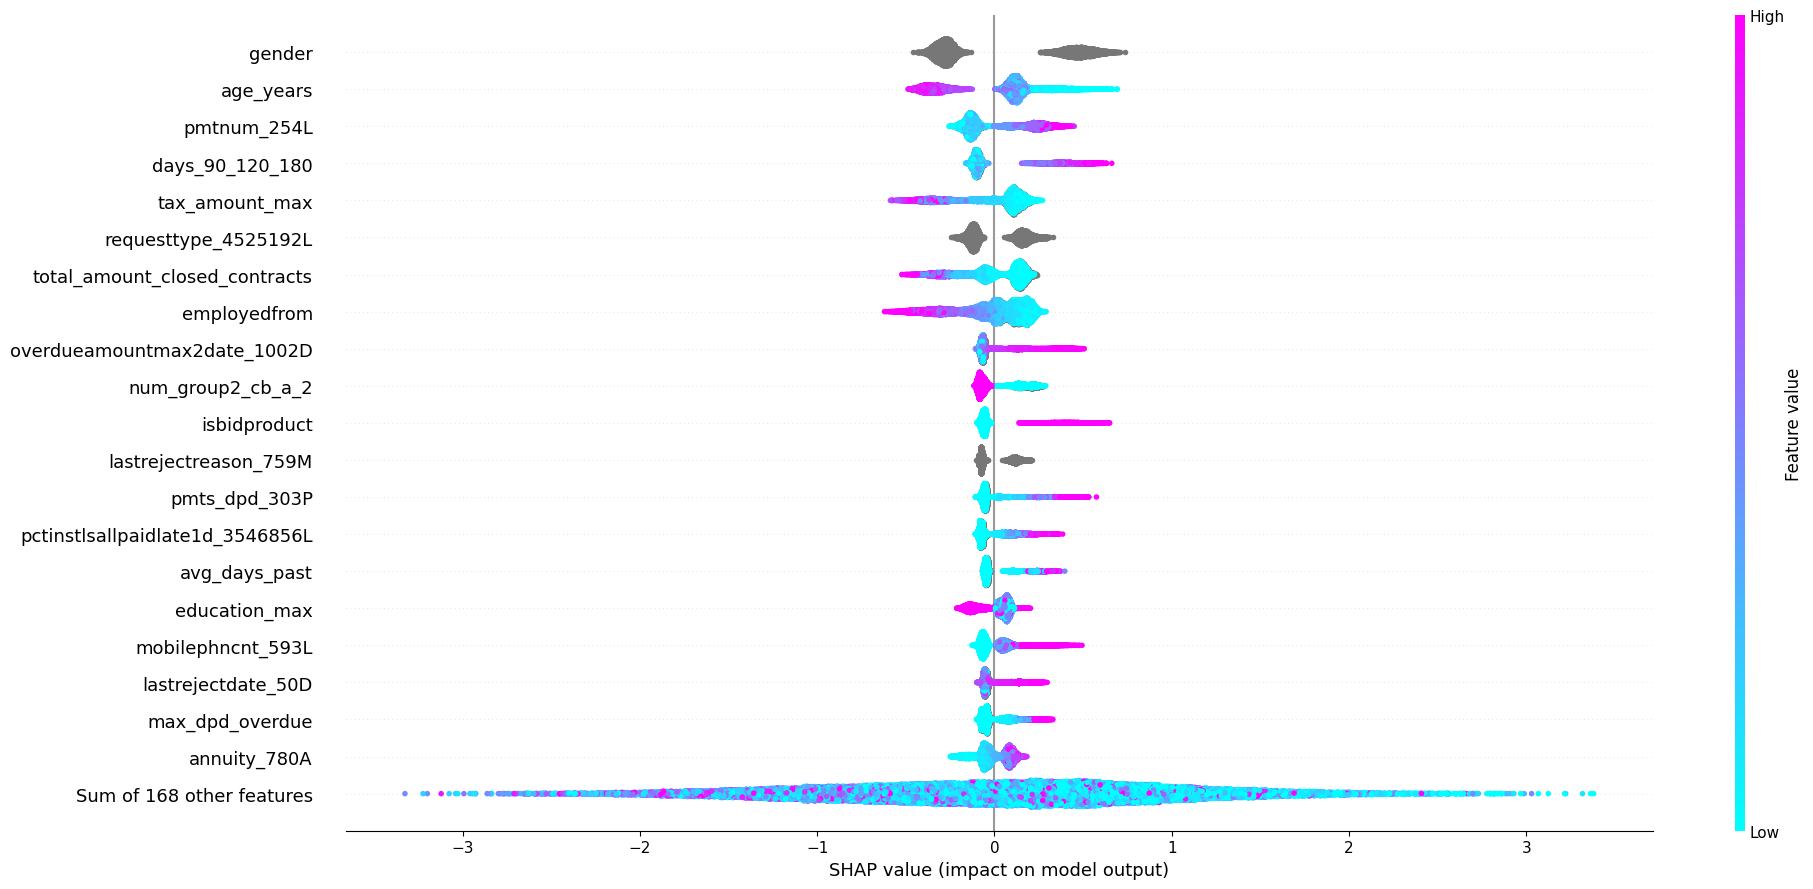

In [12]:
fig = show_beeswarm_plot(shap_values, False)

In [10]:
def show_scatter_plot(
    shap_values: np.ndarray,
    features: list[str],
    color_features: list[str],
    dark_mode: bool = True,
) -> None:
    """Plot 4 scatter plots for shap_values by 4 features

    Parameters
    ----------
    shap_values: np.ndarray
         matrix of SHAP values (# samples x # features).
         Each row sums to the difference between the model output
    features: list[str]
        4 feature names

    color_features: list[str]
        4 feature names for color map

    dark_mode: bool, default = True
        Use dark theme
    """
    assert len(features) == 4, "4 feature names must be passed"
    assert len(color_features) == 4, "4 color_features names must be passed"
    if dark_mode:
        plt.style.use("cyberpunk")
    else:
        plt.rcdefaults()
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    axis_color = "w" if dark_mode else "black"
    for i, ax_id in enumerate(list(product([0, 1], repeat=2))):
        shap.plots.scatter(
            shap_values[:, features[i]],
            ax=axes[ax_id],
            show=False,
            color=shap_values[:, color_features[i]],
            cmap=plt.get_cmap("cool"),
            axis_color=axis_color,
        )

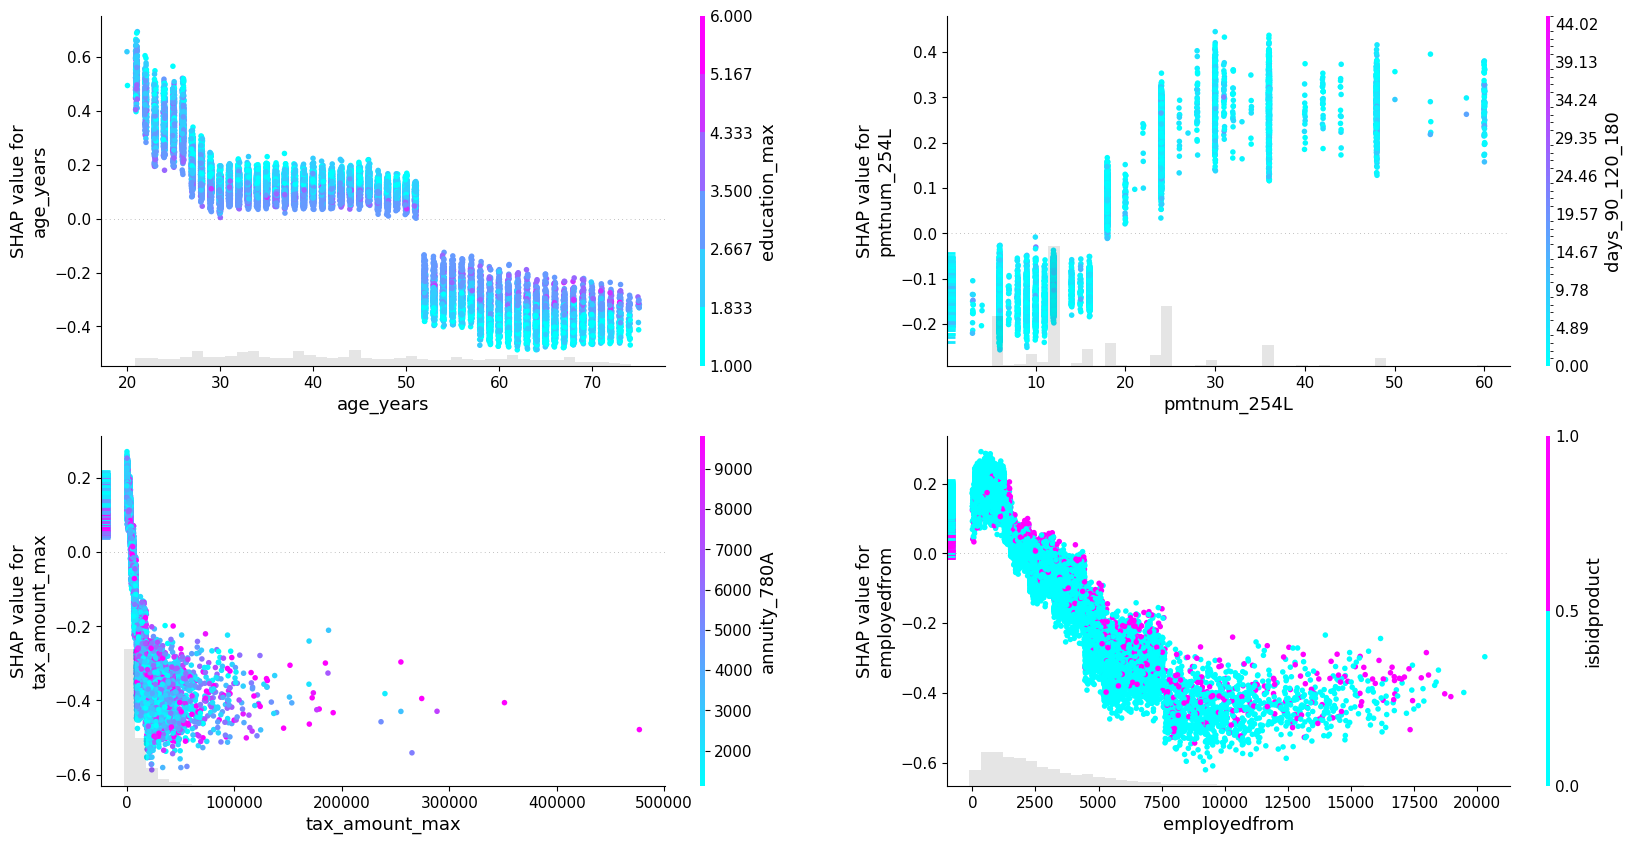

In [11]:
show_scatter_plot(
    shap_values,
    ["age_years", "pmtnum_254L", "tax_amount_max", "employedfrom"],
    ["education_max", "days_90_120_180", "annuity_780A", "isbidproduct"],
    dark_mode=False,
)

- Чем больше возраст, тем ниже в среднем вероятность дефолта. Для этой модели характерно, что клиенты моложе 50 имеют вероятность дефолта выше, чем клиенты старше 50. Причем те, кто моложе 27 в зоне риска. Также  видна зависимость от образования.
- pmtnum_254L - Общее количество платежей по кредиту, осуществленных клиентом. Начиная с ~ 19 выплат клиенты более подвержены дефолту.
- tax_amount_max: Максимальный размер налога. Чем заемщик платит больше налогов, тем ниже вероятность дефолта.
- employedfrom - Общий трудовой стаж (в днях относительно даты записи). Чем больше стаж, тем ниже вероятность дефолта.

In [81]:
def show_decision_plot(
    base_value: float,
    shap_values_legacy: np.ndarray,
    feature_names: list[str],
    dark_mode: bool = True,
) -> None:
    """Decision plot

    Parameters
    ----------
    base_value: float
        This is the reference value that the feature contributions start from. Usually, this is `explainer.expected_value`.
    shap_values_legacy: np.ndarray
         matrix of SHAP values (# samples x # features).
         Each row sums to the difference between the model output
         Taken from explainer.shap_values(X)
    feature_names: list[str]
        List of feature names (# features). If ``None``, names may be derived from the
        ``features`` argument if a Pandas object is provided. Otherwise, numeric feature
        names will be generated.
    dark_mode: bool, default = True
        Use dark theme
    """
    if dark_mode:
        plt.style.use("cyberpunk")
    else:
        plt.rcdefaults()
    axis_color = "w" if dark_mode else "black"
    shap.plots.decision(
        base_value,
        shap_values_legacy,
        feature_names=feature_names,
        axis_color=axis_color,
        y_demarc_color=axis_color,
        show=False,
    )
    plt.tight_layout()
    fig = plt.figure(plt.gcf().number, dpi=600, figsize=(20, 9))
    return fig

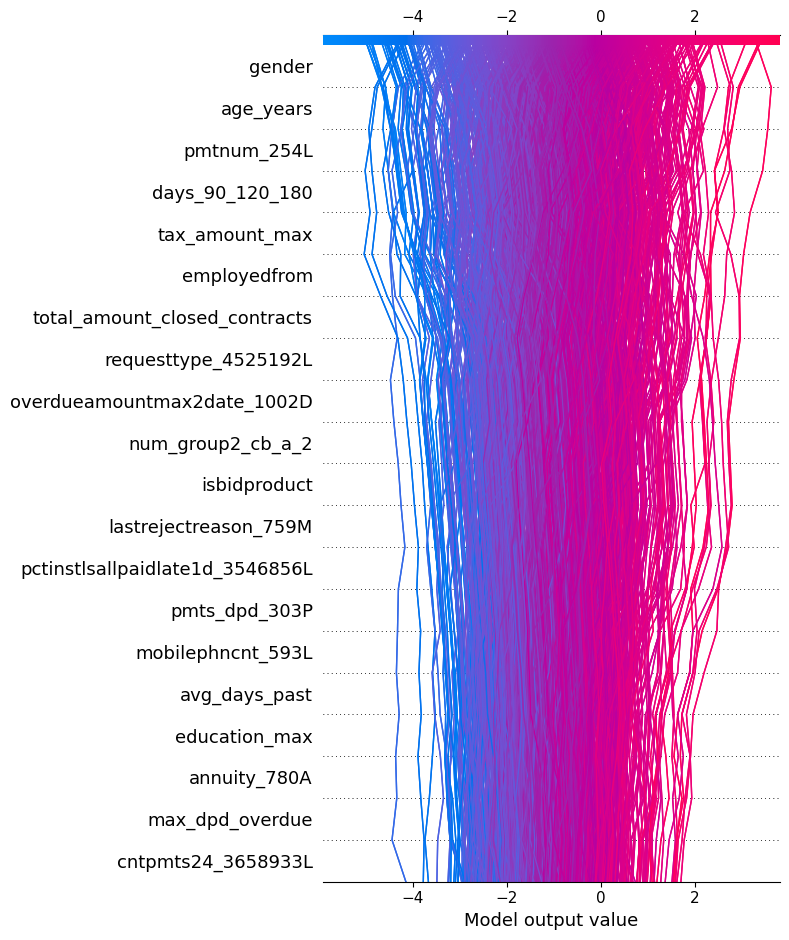

In [82]:
fig = show_decision_plot(
    explainer.expected_value,
    shap.sample(shap_values_legacy, 1000),
    X_test.columns.tolist(),
    False,
)
fig

In [33]:
def get_n_most_important_features(
    col_names: list[str], shap_values: np.ndarray, n: int
):
    """Sort shap_values by mean value and return names of N most important features.

    Parameters
    ----------
    col_names: list[str]
        List of feature names
    shap_values: np.ndarray
         matrix of SHAP values (# samples x # features).
         Each row sums to the difference between the model output
    n: int
        Number of features to return

    Parameters
    ----------
    imp_features: list[str]
        Most important features
    """
    feature_importance = pd.DataFrame(
        list(zip(col_names, shap_values.abs.mean(0).values)),
        columns=["col_name", "FI_vals"],
    )
    feature_importance.sort_values(by=["FI_vals"], ascending=False, inplace=True)
    return feature_importance.head(n)["col_name"].values

In [135]:
def show_force_plot(
    base_value: float,
    shap_values_legacy: np.ndarray,
    features: list[str] | None = None,
    feature_names: list[str] | None = None,
    dark_mode: bool = True,
) -> str:
    """Force plot

    Parameters
    ----------
    base_value: float
        This is the reference value that the feature contributions start from. Usually, this is `explainer.expected_value`.
    shap_values_legacy: np.ndarray
         matrix of SHAP values (# samples x # features).
         Each row sums to the difference between the model output
         Taken from explainer.shap_values(X)
    features: list[str]
         Matrix of feature values (# features) or (# samples x # features). This provides the values of all the
         features, and should be the same shape as the ``shap_values`` argument.
    feature_names: list[str]
         Matrix of feature names
    dark_mode: bool, default = True
        Use dark theme
    """
    force_plot = shap.force_plot(
        base_value,
        shap_values_legacy,
        features=features,
        feature_names=feature_names,
        plot_cmap="CyPU",
    )
    shap_html = f"<head>{shap.getjs()}</head><body>{force_plot.html()}</body>"
    if dark_mode:
        shap_html = re.sub(r'#000', "#FFFFFF", shap_html)
        shap_html = re.sub(r'#fff', "#000000", shap_html)
        shap_html = re.sub(r'#ccc', "#FFFFFF", shap_html)
        shap_html = re.sub(r'font-family: arial;', "font-family: arial; color: white;", shap_html)
        shap_html = re.sub(r'background: none;', "background: #212946;", shap_html)
        shap_html = "<div style='background-color:#212946;'>" + shap_html + "</div>"
    return shap_html

In [136]:
cols = get_n_most_important_features(X_test.columns, shap_values, 20)
shap_html = show_force_plot(
    explainer.expected_value, shap.sample(shap_values_legacy, 1000), cols, dark_mode=False
)
HTML(shap_html)

In [137]:
shap_html = show_force_plot(
    explainer.expected_value, shap_values_legacy[0], feature_names=X_test.columns, dark_mode=False
)
HTML(shap_html)

# Вывод

Приведен пример расчета наиболее важных признаков и вывода графиков.